# data preprocess

In [1]:
import pandas as pd
data = pd.read_csv('housing.csv')
data.dropna(axis=0,inplace =True)
data= pd.get_dummies(data,columns=['ocean_proximity'])
# data_encoded = data.drop(['ID'],axis=1)

data_encoded = data
data_encoded.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,0,0,1,0


In [2]:
from sklearn.model_selection import train_test_split
# X = data_encoded.drop(['default payment next month'], axis = 1)
# y = data_encoded['default payment next month']
X = data_encoded.drop(['median_house_value'], axis = 1)
y = data_encoded['median_house_value']
# X = data_encoded.drop(['price'], axis = 1)
# y = data_encoded['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state =12)
X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, train_size = 0.7, random_state = 12)

In [3]:
X_train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
7994,-118.15,33.85,36.0,1435.0,249.0,606.0,234.0,4.1439,1,0,0,0,0
18122,-122.01,37.32,32.0,3108.0,613.0,1577.0,603.0,4.6613,1,0,0,0,0
3996,-118.59,34.18,7.0,11853.0,2691.0,4404.0,2447.0,4.2009,1,0,0,0,0
2774,-115.80,33.26,2.0,96.0,18.0,30.0,16.0,5.3374,0,1,0,0,0
17586,-121.93,37.30,14.0,6277.0,1742.0,3025.0,1630.0,4.0653,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10335,-117.78,33.82,12.0,6208.0,750.0,2443.0,739.0,9.1808,1,0,0,0,0
3044,-119.27,35.50,34.0,1367.0,329.0,796.0,319.0,2.8269,0,1,0,0,0
13490,-117.38,34.06,17.0,3139.0,569.0,1612.0,516.0,3.3571,0,1,0,0,0
8875,-118.49,34.05,52.0,2416.0,291.0,810.0,270.0,13.8556,1,0,0,0,0


In [4]:
def train(model, device, epoch, train_data_loader, criterion, optimizer):
    for index, (tmp_x, tmp_y) in enumerate(train_data_loader):
        outputs = model(tmp_x.to(device))
#         print(outputs.shape)
        loss = criterion(outputs, tmp_y.unsqueeze(dim=1).to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss

In [36]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from sklearn.preprocessing import StandardScaler

from torchcp.regression.predictors import SplitPredictor, CQR
from torchcp.regression.loss import QuantileLoss
from torchcp.utils import fix_randomness
from utils import build_reg_data, build_regression_model

##################################
# Preparing dataset
##################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
fix_randomness(seed=1)


# 标准化处理
scalerX = StandardScaler()
scalerX.fit(X_train)
X_train_scaled = scalerX.transform(X_train)
X_test_scaled = scalerX.transform(X_test)
X_cal_scaled = scalerX.transform(X_cal)
# print(X_train)
# X_train_scaled = X_train.values
# X_test_scaled = X_test.values
# X_cal_scaled = X_cal.values


# 创建TensorDataset和DataLoader
train_dataset = TensorDataset(torch.from_numpy(X_train_scaled).to(torch.float32), torch.from_numpy(y_train.values).to(torch.float32))
test_dataset = TensorDataset(torch.from_numpy(X_test_scaled).to(torch.float32), torch.from_numpy(y_test.values).to(torch.float32))
cal_dataset = TensorDataset(torch.from_numpy(X_cal_scaled).to(torch.float32), torch.from_numpy(y_cal.values).to(torch.float32))
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True,drop_last=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, pin_memory=True,drop_last=True)
cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=64, shuffle=True, pin_memory=True,drop_last=True)
print("done")

print(type(X_train_scaled))

done
<class 'numpy.ndarray'>


# Simple network regression

########################## SplitPredictor ###########################


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NonLinearNet(
  (base_model): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)


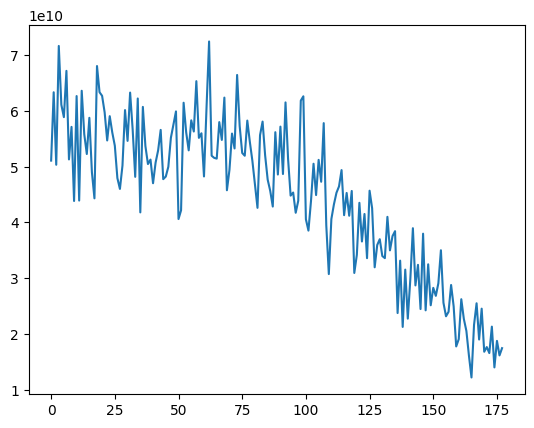

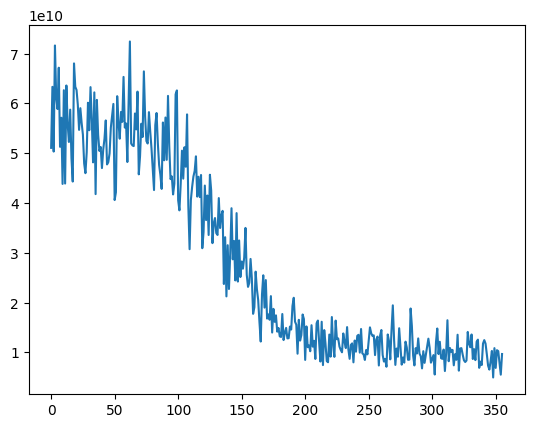

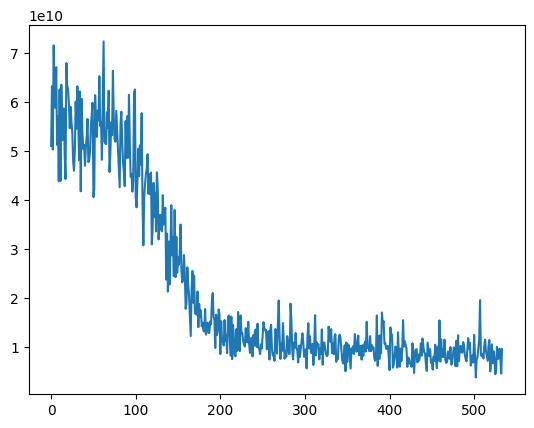

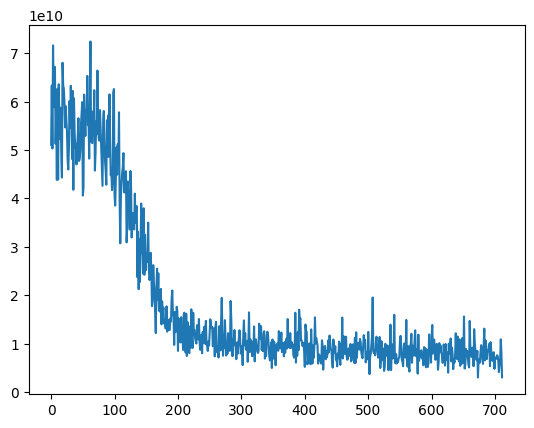

In [6]:
# 设置超参数
epochs = 4
alpha = 0.05

##################################
# Split Conformal Prediction
##################################
print("########################## SplitPredictor ###########################")

# Set output dimension 1 means simple regression network.
model = build_regression_model("NonLinearNet")(X_train_scaled.shape[1], 1, 64, 0.5).to(device)
# Use simple MESloss for precise regression
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

loss_store = []
print(model)
for epoch in range(epochs):
    for index, (tmp_x, tmp_y) in enumerate(train_data_loader):
        outputs = model(tmp_x.to(device))
#         print(outputs)
#         print(outputs,tmp_y)
        loss = criterion(outputs, tmp_y.unsqueeze(dim=1).to(device))
#         print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_store.append(loss.detach().cpu().numpy())
    plt.plot(loss_store)
    plt.show()
    plt.close()
    
#     train(model, device, epoch, train_data_loader, criterion, optimizer)


In [7]:
model.eval()
# Use Splitpredictor for direct conformal prediction.
predictor = SplitPredictor(model)
predictor.calibrate(cal_data_loader, alpha)
print(predictor.evaluate(cal_data_loader))

{'Coverage_rate': 0.9510690569877625, 'Average_size': 321058.9375}


## Conformal regression

########################## CQR ###########################


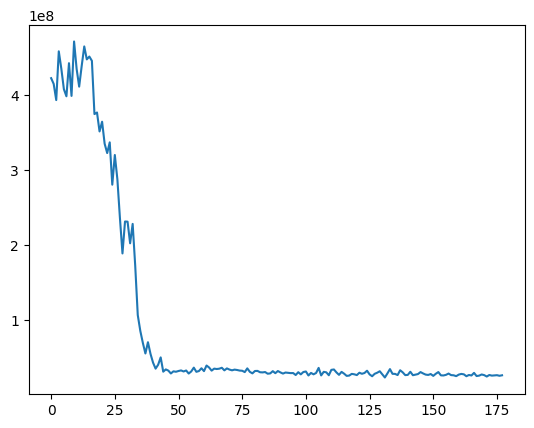

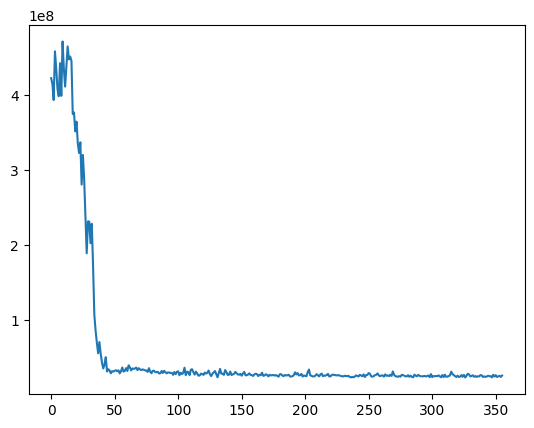

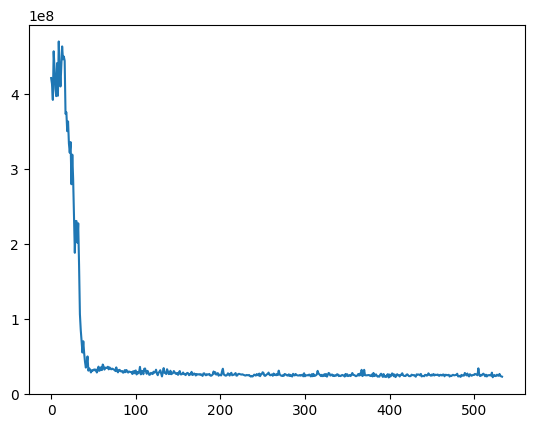

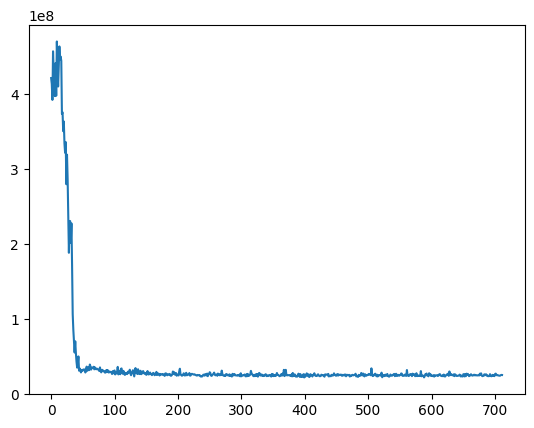

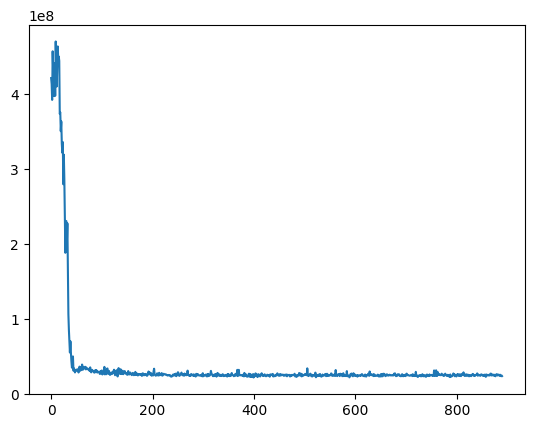

In [8]:
epochs = 5

print("########################## CQR ###########################")
quantiles = [alpha / 2, 1 - alpha / 2]
# 2-dim output for upper and lower bounds prediction.
model_cp = build_regression_model("NonLinearNet")(X_train_scaled.shape[1], 2, 64, 0.1).to(device)
# Use QuantileLoss for conformal regression
criterion = QuantileLoss(quantiles)
optimizer = torch.optim.Adam(model_cp.parameters(), lr=0.1)

loss_store2 = []
for epoch in range(epochs):
#     print(epoch)
    for index, (tmp_x, tmp_y) in enumerate(train_data_loader):
        outputs = model_cp(tmp_x.to(device))
#         print(outputs.shape[0])
        loss = criterion(outputs, tmp_y.unsqueeze(dim=1).to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_store2.append(loss.detach().cpu().numpy())
    
#     loss_store2.append(train(model_cp, device, epoch, train_data_loader, criterion, optimizer).detach().cpu().numpy())
    plt.plot(loss_store2)
    plt.show()
    plt.close()

In [26]:
##################################
    # Conformal Quantile Regression
##################################
# print("########################## CQR ###########################")
# quantiles = [alpha / 2, 1 - alpha / 2]
# model_cp = build_regression_model("NonLinearNet")(X.shape[1], 2, 64, 0.5).to(device)
# criterion = QuantileLoss(quantiles)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# for epoch in range(epochs):
#     train(model_cp, device, epoch, train_data_loader, criterion, optimizer)

model_cp.eval()
predictor2 = CQR(model_cp)
predictor2.calibrate(cal_data_loader, alpha)
print(predictor2.evaluate(test_data_loader))

{'Coverage_rate': 0.9494048357009888, 'Average_size': 431845.15625}


In [47]:
# model_cp.eval()
import numpy as np
predictor2 = CQR(model_cp)
predictor2.calibrate(cal_data_loader, alpha)
low = []
true = []
high = []
pre = []
# print(model.device())
for index, tmp in enumerate(cal_data_loader):
    tmp_x = tmp[0]
    tmp_y = tmp[1]
#     predictor2 = CQR(model_cp)
#     predictor2.calibrate(torch.utils.data.DataLoader(TensorDataset(torch.tensor(tmp[0]),torch.tensor(tmp[1]))), alpha)
#     a = model_cp(tmp_x.to(device))
    a = predictor2.predict(tmp_x)
    ori = model(tmp_x.to(device))
    pre.append(ori[:,0].detach().cpu().numpy())
    low.append(a[:,0].detach().cpu().numpy())
    high.append(a[:,1].detach().cpu().numpy())
    true.append(tmp_y.detach().cpu().numpy())
#     print(ori,true)

#     tensor = torch.cat((b.unsqueeze(1), y.unsqueeze(1)), dim=1)
#     tensor = torch.cat((tensor, c.unsqueeze(1)), dim=1)
#     print(tensor)
low = np.array(low).reshape(-1)
high = np.array(high).reshape(-1)
true = np.array(true).reshape(-1)
pre = np.array(pre).reshape(-1)
print(len(low),len(high),len(true),len(pre))
print(predictor2.evaluate(cal_data_loader))

[498501.97 476243.28 483911.78 ... 490618.6  471265.5  479612.47]
4864 4864 4864 4864
{'Coverage_rate': 0.9500411152839661, 'Average_size': 431836.21875}


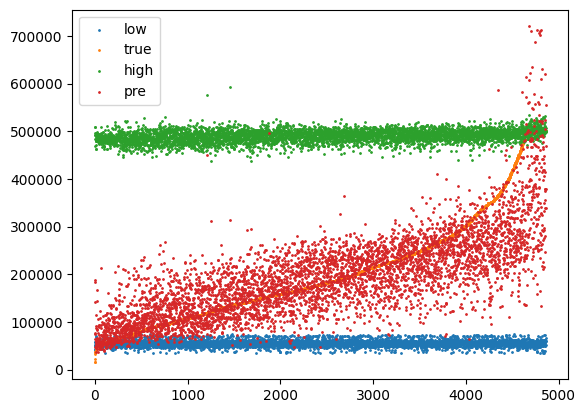

In [43]:
# 创建一个新的图
plt.figure()


indices = np.argsort(true)
low = low[indices]
high = high[indices]
true = true[indices]
pre = pre[indices]

# 在图上画出三个数组
# plt.plot(low, label='Array 1')
# plt.plot(true, label='Array 2')
# plt.plot(high, label='Array 3')

# 在图上画出三个数组
plt.scatter(range(len(low)), low, label='low',s=1)
plt.scatter(range(len(true)), true, label='true',s=1)
plt.scatter(range(len(high)), high, label='high',s=1)
plt.scatter(range(len(pre)), pre, label='pre',s=1)

# 添加图例
plt.legend()

# 显示图
plt.show()